In [53]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from model import loss
from model import reverse_se3_diffusion
import tree
from data import rosetta_data_loader
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation

from omegaconf import OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [54]:
importlib.reload(rosetta_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(reverse_se3_diffusion)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [69]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')
# rocklin_conf = OmegaConf.load('../config/sanity_check_rocklin.yaml')
# debug_conf = OmegaConf.load('../config/debug.yaml')
# conf = OmegaConf.merge(conf, rocklin_conf)

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.num_epoch = 10000
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

data_conf = conf.data
data_conf.rosetta.max_examples = 1
data_conf.rosetta.max_len = 100
data_conf.rosetta.use_rocklin = True

diff_conf = conf.diffuser
diff_conf.diffuse_trans = True

model_conf = conf.model
model_conf.num_blocks = 1

# print(OmegaConf.to_yaml(conf))

In [70]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
chosen_gpu = ''.join(
    [str(x) for x in GPUtil.getAvailable(order='memory')])
os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu

In [71]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 1251854
INFO: Checkpoint not being saved.


Using cached IGSO3.
Using R^3 VP-SDE


INFO: Training: 1 examples
INFO: Validation: 1 examples


## Training

In [72]:
num_epochs = 2
step = 0
epoch = 0
train_losses = defaultdict(list)
log_losses = defaultdict(list)
latest_aux_data = []
sampled_ts = []
def update_logs(x,y):
    for k in y:
        if 'loss' in k:
            x[k].append(y[k])
log_freq = 100

exp._model = exp._model.to(device)
exp._model.train()
while epoch < num_epochs:
    epoch += 1
    for train_features in train_loader:
        step += 1
        exp.step = step
        exp.num_epochs = epoch
        sampled_ts.append(train_features['t'])
        train_features = tree.map_structure(
            lambda x: x.to(device), train_features)
        _, aux_data = exp.update_fn(train_features)
        aux_data = tree.map_structure(du.move_to_np, aux_data)
        latest_aux_data.append(aux_data)
        update_logs(train_losses, aux_data)
        update_logs(log_losses, aux_data)
        if step == 1 or step % log_freq == 0:
            print_log = f'Step {step}: '
            for k,v in log_losses.items():
                print_log += f'{k}={np.mean(v):.4f} '
            print(print_log)
            log_losses = defaultdict(list)
            latest_aux_data = []

Step 1: total_loss=6.1989 rot_loss=3.1099 trans_loss=3.0889 


Text(0, 0.5, 'Total loss')

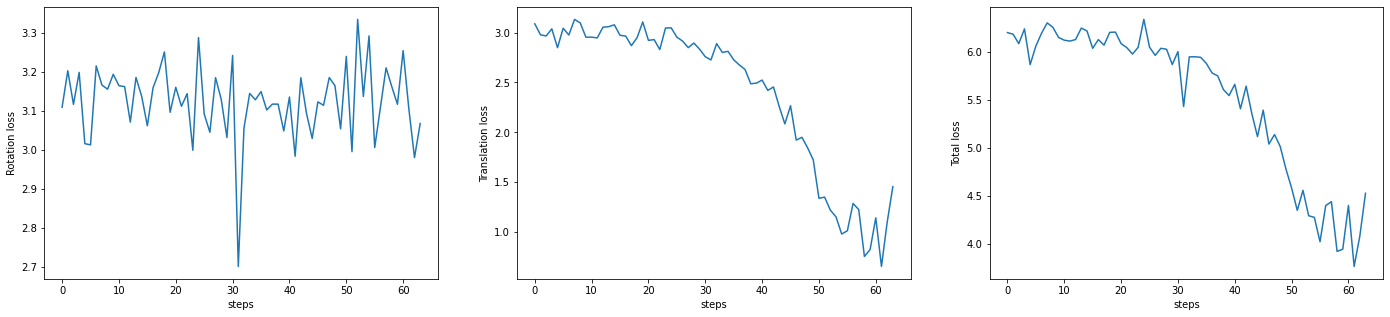

In [73]:
f, axes = plt.subplots(1, 3, figsize=[24, 5])

axes[0].plot(train_losses['rot_loss'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('Rotation loss')

axes[1].plot(train_losses['trans_loss'])
axes[1].set_xlabel('steps')
axes[1].set_ylabel('Translation loss')

axes[2].plot(train_losses['total_loss'])
axes[2].set_xlabel('steps')
axes[2].set_ylabel('Total loss')

## Equivariance test

In [74]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [75]:
b_idx = 0
data_raw = tree.map_structure(lambda x: x.to(device)[b_idx:b_idx+1], raw_data_feats)
res_mask = data_raw['res_mask'].bool()
data_raw['rigids_0'] = data_raw['rigids_0'][torch.where(res_mask)][None]
data_raw['atom_positions'] = data_raw['atom_positions'][torch.where(res_mask)][None]
data_raw['rigids_t'] = data_raw['rigids_t'][torch.where(res_mask)][None]
data_raw['res_mask'] = data_raw['res_mask'][torch.where(res_mask)][None]
data_raw['res_idx'] = data_raw['res_idx'][torch.where(res_mask)][None]
# gt_frames = Rigid.from_tensor_7(data_raw['rigids_0'])

In [76]:
data_perturbed = copy.deepcopy(data_raw)
atom_pos = du.move_to_np(data_raw['atom_positions'])
res_mask = du.move_to_np(data_raw['res_mask'])
rand_rot = Rotation.random().as_matrix()

# perturbed_atom_pos = np.einsum('ij,...i->...j', rand_rot, atom_pos) + 10.0
# perturbed_atom_pos = atom_pos + 10.0
perturbed_atom_pos = np.einsum('ij,...i->...j', rand_rot, atom_pos)
# perturbed_atom_pos = atom_pos @ rand_rot

perturbed_atom_pos *= res_mask[..., None, None]
perturbed_frames = du.rigid_frames_from_all_atom(
    torch.Tensor(perturbed_atom_pos[0]).to(device))
data_perturbed['rigids_0'] = perturbed_frames.to_tensor_7()[None]
data_perturbed['rigids_t'] = perturbed_frames.to_tensor_7()[None]

In [77]:
model_out = exp.model(data_raw)
model_out_perturbed = exp.model(data_perturbed)

trans_out = du.move_to_np(model_out['trans_score'][0])
trans_out_perturbed = du.move_to_np(model_out_perturbed['trans_score'][0])

rot_out = du.move_to_np(model_out['rot_score'][0])
rot_out_perturbed = du.move_to_np(model_out_perturbed['rot_score'][0])

In [78]:
model_out.keys()

dict_keys(['rot_score', 'trans_score', 'local_trans_score'])

In [79]:
model_out['local_trans_score'][0, :3]

tensor([[-2.2665, -0.5985, -0.2933],
        [-0.8644, -0.1428, -0.3190],
        [ 0.0319, -0.0879,  1.6200]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [80]:
model_out_perturbed['local_trans_score'][0, :3]

tensor([[ 0.1001, -0.9136,  0.9115],
        [-0.1790, -0.5206, -0.7893],
        [ 0.0047, -1.2598, -0.0431]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [22]:
trans_out_perturbed[res_mask[0].astype(bool)][:5]

array([[-0.27740687,  0.03016962, -0.7073782 ],
       [-0.5119525 ,  0.18183756, -0.83036005],
       [-0.08131701, -0.2692366 , -1.1522807 ],
       [ 0.271326  ,  0.13480344, -0.8479429 ],
       [-0.31241408,  0.20407097, -0.34713554]], dtype=float32)

In [23]:
np.einsum('ij,...i->...j', rand_rot, trans_out)[res_mask[0].astype(bool)][:5]

array([[-0.00672061,  1.00939334,  0.07731453],
       [ 0.41935569,  0.39103092, -1.68513551],
       [ 0.14905348,  2.14237401, -0.39490131],
       [ 0.42325214, -0.25644193, -0.50698449],
       [ 1.32466338, -0.06404343, -0.31480239]])

In [24]:
rot_out[res_mask[0].astype(bool)][:5]

array([[-0.03732781,  0.02963429, -0.01629336],
       [-0.10716951, -0.00991597, -0.01224569],
       [-0.02636492,  0.10104843,  0.03481051],
       [-0.04788515,  0.0075866 ,  0.00568782],
       [ 0.01960205,  0.05582193,  0.0341166 ]], dtype=float32)

In [25]:
rot_out_perturbed[res_mask[0].astype(bool)][:5]

array([[-0.01820527,  0.00933428, -0.00086865],
       [-0.06082387, -0.04192065, -0.04625566],
       [-0.04434459, -0.050708  , -0.04268268],
       [-0.06593413, -0.04110622, -0.0279163 ],
       [-0.05032446, -0.01084349, -0.02319771]], dtype=float32)

## Data visualization

In [ ]:
train_iter = iter(train_loader)
next_item = next(train_iter)
print(next_item['t'])

In [ ]:
# Rigid process function
scale_factor = conf.data.rosetta.scale_factor
bb_mask = next_item['res_mask'].bool()
def process_rigids(rigids, b_idx):
    np_rigids = du.move_to_np(rigids[b_idx][bb_mask[b_idx]])
    se3_vec = au.rigids_to_se3_vec(np_rigids, scale_factor=scale_factor)
    return np_rigids, se3_vec

In [ ]:
# Visualize example
rigids_t, noisy_se3_vec = process_rigids(next_item['rigids_t'], 0)
rigids_0, gt_se3_vec = process_rigids(next_item['rigids_0'], 0)


In [ ]:
ax_lim = 10
f, axes = plt.subplots(1, 2, figsize=[16, 8], subplot_kw=dict(projection="3d"))
plotting.plot_se3(gt_se3_vec, ax=axes[0], title='Initialization', ax_lim=ax_lim)
plotting.plot_se3(noisy_se3_vec, ax=axes[1], title='Sampled frame', ax_lim=ax_lim)

## Sampling

In [37]:
exp_diffuser = exp.diffuser

In [46]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [49]:
batch_idx = 1
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.random_init(num_res).to_tensor_7()
rigids_init *= res_mask[:, None]
sample_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
    't': torch.tensor(exp_diffuser.num_t),
}
sample_feats = tree.map_structure(lambda x: x[None].to(device), sample_feats)

In [50]:
# Run reverse diffusion
reverse_steps = list(reversed(range(exp.diffuser.num_t)))
all_steps = [copy.deepcopy(sample_feats['rigids_t'])]
for t in reverse_steps[:-1]:
    sample_feats['t'] = (
        t * torch.ones_like(
            sample_feats['t'],
            device=device)).to(device)
    with torch.no_grad():
        model_out = exp.model(sample_feats)
    rot_score = model_out['rot_score']
    trans_noise = model_out['trans_score']
    sample_feats['rigids_t'] = exp.diffuser.reverse_sample(
        sample_feats['rigids_t'],
        rot_score,
        trans_noise,
        sample_feats['t'],
        torch.ones_like(sample_feats['res_mask']),
        add_noise=False
    )
    all_steps.append(copy.deepcopy(sample_feats['rigids_t']))

In [51]:
def viz_frames(rigids, mask, ax, scale_factor=10.0, title='', ax_lim=10.0):
    viz_mask = du.move_to_np(mask).astype(bool)
    frames = du.move_to_np(rigids)[viz_mask]
    se3_vec = au.rigids_to_se3_vec(frames, scale_factor=scale_factor)
    plotting.plot_se3(se3_vec, ax=ax, title=title, ax_lim=ax_lim)

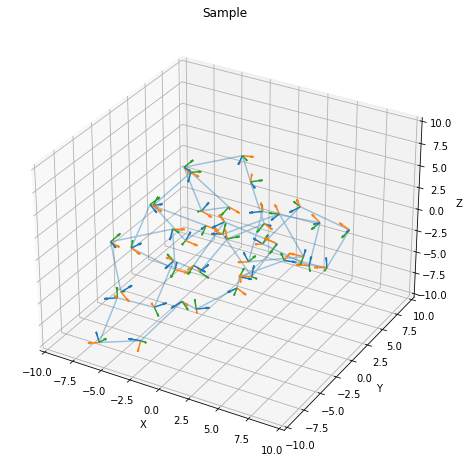

In [54]:
final_rigid = all_steps[-1][0]
f, axes = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
viz_frames(final_rigid, res_mask, axes, title='Sample', scale_factor=conf.data.rosetta.scale_factor)

In [59]:
def compute_fape(pred_frame, target_frame, mask, length_scale=1.0):
    pred_frame = ru.Rigid.from_tensor_7(pred_frame)
    target_frame = ru.Rigid.from_tensor_7(target_frame)
    return loss.bb_fape_loss(
        pred_frames=pred_frame,
        target_frames=target_frame,
        frames_mask=mask,
        positions_mask=mask,
        pred_positions=pred_frame.get_trans(),
        target_positions=target_frame.get_trans(),
        l1_clamp_distance=10.0,
        length_scale=length_scale,
        eps=1e-4,
        ignore_nan=True,
    )

In [62]:
compute_fape(final_rigid, rigids_0.to(final_rigid.device), res_mask.to(final_rigid.device))

tensor(0.2081, device='cuda:0', dtype=torch.float64)